# COMP6252 - Deep Learning Technologies Coursework 2

## Install packages

* torch : An open-source machine learning library for Python. Offers an adaptable framework for neural network building and training.

* torchvision : Provides  tools and utilities for working with computer vision tasks.

*  librosa : A Python library used for audio and music analysis.

In [1]:
!pip install torch
!pip install torchvision
!pip install librosa

## Import necessary Packages

We'll now import the packages needed to execute the project properly.
These Python packages/modules are often used for multiple purposes in deep learning, data processing, visualization, and evaluation:

* os: Provides access to functions specific to your operating system.
  
* torch nn: This module, when used with PyTorch, makes it easier to build neural network topologies.

* torch.nn.functional: Provides a set of functions helpful for neural network operations that may be applied on tensors.
  
* torch.optim: The optimization algorithms in this module are used to optimize neural network parameters during training.
  
* Torchvision: Contains model architectures, image transformations, and commonly used datasets for computer vision applications.
  
* PIL (Python Imaging Library) allows for opening, editing, and saving many picture file formats.

* transforms: Provides common image transformations such as scaling, cropping, and normalizing for preprocessing purposes.

* datasets: Provides the ability to download and load popular datasets.

* ImageFolder: Enables the development of a dataset made up of photographs arranged into folders, each representing a class.

* DataLoader: Creates iterable data loaders for training and evaluation, allowing for batch data lod on them.

* Pandas : a robust Python data processing package. Provides functions and data structures for handling time series data and numerical tables.
  
* NumPy : a key Python package for scientific computing. Large, multidimensional arrays and matrices are supported, and a variety of mathematical operations may be performed on them.

* zipfile: Supports writing, reading, listing, appending, and creating ZIP files.
  
* Seaborn : a Matplotlib-based library for data visualization. Provides a powerful sketching tool for producing appealing and statistical visualizations.
  
* matplotlib.pyplot: Provides an interface for creating plots and visualizations comparable to MATLAB.data in batches.

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import torch.optim as optim 
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import SGD, Adam
import pandas as pd
import numpy as np
import librosa
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

## Importing the Dataset 

We can upload the dataset from our files by identifying the appropriate part, or we can utilize Kaggle to do it.

#### Class LoadDataset:

This is used to import audio files from a directory and label them based on the subfolder names. It loads each audio file, performs optional changes, and provides audio data with a label.

In [3]:
# Create a class named LoadDataset that inherits from the Dataset class.
class LoadDataset(Dataset):
    # Initialize the class with a data directory and optional transformations.
    def __init__(self, data_dir, transform=None):
        
        # Store the data directory.
        self.data_dir = data_dir
        # Store the transformation.
        self.transform = transform   
        # Retrieve a list of subdirectories (classes) within the data directory.
        self.classes = os.listdir(data_dir)        
        # Create an empty list for storing samples.
        self.samples = []
        
        # Iterate over each class using an index.
        for i, genre in enumerate(self.classes):
            # Obtain the directory path for the current class.
            genre_dir = os.path.join(data_dir, genre)
            
            # Iterate over every file in the class directory.            
            for file in os.listdir(genre_dir):
                # Add a tuple containing the file location and label index to the samples list.
                self.samples.append((os.path.join(genre_dir, file), i))

    
    # Define a method that returns the dataset's length.
    def __len__(self):
        # Return the number of samples in the dataset.
        return len(self.samples)

    
    # Define a method for retrieving a sample using an index.
    def __getitem__(self, idx):
        # Retrieve the file location and label of the sample at the specified index.
        file_path, label = self.samples[idx]        
        # Load audio file using librosa.
        audio, _ = librosa.load(file_path, sr=None)
        
        # Apply transformations if any.
        if self.transform:            
            # Perform the transformations on the audio.
            audio = self.transform(audio)

        # Return the audio data with its associated label.
        return audio, label

#### Class TransformDataset:

This transformation class resamples audio at a defined rate, normalizes it within the range [-1, 1], and sets its length to a maximum value.

In [4]:
# Create a class for audio data transformation.
class TransformDataset:
    # Initialize the transformation parameters.
    def __init__(self, sample_rate=22050, max_length=220500):
        # Store the sample rate.
        self.sample_rate = sample_rate
        # Save the maximum length of audio.
        self.max_length = max_length

    
    # Define the transformation technique.
    def __call__(self, audio):        
        # Resample audio to the specified sample rate using librosa.
        audio = librosa.resample(audio, orig_sr=self.sample_rate, target_sr=self.sample_rate)
        # Normalize audio to the range [-1, 1] by dividing by the highest absolute value.
        audio /= np.max(np.abs(audio))
        
        # Ensure all audio samples have the same length.
        # Determine if the audio length is less than the maximum length.
        if len(audio) < self.max_length:            
            # Pad the audio sequence with zeros if it's shorter than max_length.
            audio = np.pad(audio, (0, self.max_length - len(audio)))
            
        else:
            # If audio sequence is greater than max_length, truncate it.
            audio = audio[:self.max_length]

        # Return the converted audio.
        return audio

In [5]:
# Create transforms for audio data.
audio_transform = TransformDataset()

In [6]:
# Load audio data.
data_dir = 'C:/Users/DELL/Downloads/DLTCW/music-genre-dataset/Data/genres_original'
dataset = LoadDataset(data_dir, transform=audio_transform)

In [7]:
# !pip install kaggle
# from google.colab import files
# files.upload()  # Select the kaggle.json file from your local machine

In [8]:
# Move the API key to the required location
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
# !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

# Unzip the dataset
# with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
 #    zip_ref.extractall('gtzan_dataset')

# List the contents of the extracted folder
# !ls gtzan_dataset

In [9]:
# Define the path to your dataset folder
# data_dir = 'gtzan_dataset/Data/genres_original'

# Load the dataset using LoadDataset
# dataset = datasets.LoadDataset(data_dir, transform=audio_transform)

In [10]:
# Determine the number of classes and extract their names from the dataset for analysis.
num_classes = len(dataset.classes)
class_names = dataset.classes

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [11]:
# Calculate the total number of audios in the dataset
num_images = len(dataset)
print("Total number of audio samples:", num_images)

Total number of audio samples: 1000


### Split the dataset

Divide a dataset into three independent sets: training, validation, and testing. The size of each subset is determined by preset proportions—70% for training, 20% for validation, and the remainder for testing. 
Using PyTorch's random_split() method, the dataset is randomly divided into the required proportions. 

In [12]:
# Set the size of each split.
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Randomly partition the dataset.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Verify the sizes of each split.
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 700
Validation set size: 200
Test set size: 100


### Define Data loaders

We set up the data loaders. 
Every loader is designed to function with a certain subset of the dataset, whether for testing, validation, or training. 

While the 'val_loader' and 'test_loader' use the same batch size, they do not shuffle their datasets, which is a usual practice for validation and test data to maintain consistency throughout assessment. The 'train_loader' is set to a batch size of 32 and supports data shuffling to introduce unpredictability during training epochs. 
No additional processes are created to load data, as evidenced by the option 'num_workers' being set to 0 across all loaders. 

Configuring these loaders improves efficiency and makes it easier to train and evaluate models on various subsets.

In [13]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [14]:
print(f"Number of batches in training DataLoader: {len(train_loader)}")
print(f"Number of batches in validation DataLoader: {len(val_loader)}")
print(f"Number of batches in test DataLoader: {len(test_loader)}")

Number of batches in training DataLoader: 22
Number of batches in validation DataLoader: 7
Number of batches in test DataLoader: 4


In [15]:
# Print the size of the first batch of each DataLoader.
for loader_name, loader in zip(["training", "validation", "test"], [train_loader, val_loader, test_loader]):
    print(f"\nSize of the first batch in {loader_name} DataLoader:")
    for audios, labels in loader:
        print("Audios shape:", audios.shape)
        print("Labels shape:", labels.shape)
        break


Size of the first batch in training DataLoader:
Audios shape: torch.Size([32, 220500])
Labels shape: torch.Size([32])

Size of the first batch in validation DataLoader:
Audios shape: torch.Size([32, 220500])
Labels shape: torch.Size([32])

Size of the first batch in test DataLoader:
Audios shape: torch.Size([32, 220500])
Labels shape: torch.Size([32])


Based on CUDA availability, this line of code chooses the device (CPU or GPU) for PyTorch operations. It sets the device to 'cuda' for CUDA-enabled GPUs; if not, it defaults to 'cpu' for CPU-based processing.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We now check the shape of inputs array.

In [17]:
# Determine the form of the 'audios' array.
inputs= audios.shape

# Print the shape of the input array.
print('Input shape:', inputs)

Input shape: torch.Size([32, 220500])


### Function train_model

This function train_model manages the training of a given model across a predetermined number of epochs, using specific criteria, optimizer, and data loader. It iterates through each epoch, computing loss, performing backpropagation, and adjusting model parameters as needed, all while recording the average loss of each epoch to measure training progress.

In [18]:
# Define the training function.
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    # Set the model to training mode.
    model.train()
    
    # Iterate over each epoch.
    for epoch in range(num_epochs):
        # Set running loss.
        running_loss = 0.0
        
        # Iterate over each batch in the training loader.
        for audios, labels in train_loader:
            # Transfer data to the device.
            audios, labels = audios.to(device), labels.to(device) 
            # Set the parameter gradients to zero.
            optimizer.zero_grad()
            # Forward Pass.
            outputs = model(audios)
            # Calculate the loss amount.
            loss = criterion(outputs, labels)
            # Backward pass.
            loss.backward()
            # Update the weights.
            optimizer.step()
            # Calculate the loss.
            running_loss += loss.item() * audios.size(0)

        # Calculate epoch loss.
        epoch_loss = running_loss / len(train_loader.dataset)
        # Print the epoch loss.
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

### Function evaluate_model

This function, evaluate_model is crucial for evaluating a model's performance with a specified data loader. It switches the model into evaluation mode to prohibit parameter modifications during evaluation. Predictions for data samples are generated while the data loader iterates through each batch. By comparing these predictions to the actual labels, it calculates the model's accuracy on the dataset. This function is an important tool for assessing a model's capacity to generalize to previously encountered data without changing its parameters.

In [19]:
# Define the evaluation function.
def evaluate_model(model, data_loader):
    # Set the model to evaluation mode.
    model.eval()
    # Initialize the amount of correctly predicted samples and the total number of samples.
    correct = 0
    total = 0

    # Disable gradient evaluation.
    with torch.no_grad():
        # Iterate over each batch in the data loader.
        for audios, labels in data_loader:
            # Transfer data to device.
            audios, labels = audios.to(device), labels.to(device)
            # Forward pass.
            outputs = model(audios)
            # Calculate predicted labels.
            _, predicted = torch.max(outputs.data, 1)
            # Increase total count by batch size.
            total += labels.size(0)
            # Count correct predictions.
            correct += (predicted == labels).sum().item()

    # Calculate accuracy and return it.
    accuracy = correct / total
    return accuracy

### Function get_all_predictions

This function, 'get_all_predictions', runs in evaluation mode and iterates through the specified data loader. It predicts audio samples using a trained algorithm. These forecasts, together with their respective ground truth labels, are gathered and returned. The function enables the aggregation of all predictions and ground truth labels from the dataset, which is required for further analysis and assessment of the model's performance.

In [20]:
def get_all_predictions(model, data_loader):
    # Set up lists to contain all predictions and ground truth labels.
    all_predictions = []
    all_targets = []
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over each batch in the data loader
        for audios, labels in data_loader:
            # Transfer data to the proper device.
            audios, labels = audios.to(device), labels.to(device)
            # Forward Pass
            outputs = model(audios)
            # Obtain predicted labels.
            _, predicted = torch.max(outputs, 1)
            # Expand the list of predictions and ground truth labels.
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Return all predicted and ground truth labels.
    return all_predictions, all_targets

# Two architectures:
## 1. An RNN network with LSTMs.

This code develops a neural network model named 'Net5' with PyTorch's 'nn.Module' class. It is intended for sequence data processing, most likely for applications like time series prediction or sequence categorization. 

Initiation ('__init__'): 
 - Sets up the LSTM layer with the provided input size, hidden size, number of layers, and output classes. 
 - Also creates a fully linked (linear) layer for categorization. 

  Forward Pass ('forward'):
- Reshapes the input tensor 'x' to include a third dimension for batch size.
 - Sets the hidden and cell states ('h0' and 'c0') of the LSTM to zeros.
 - Sends the input through the LSTM layer ('self.lstm') to produce the output sequence 'out'.
 - Indexes the output from the sequence's last time step ('out[:, -1,:]').
 - To acquire the final output, pass this last time step output via the fully connected layer ('self.fc').

In summary, this model runs input sequences through an LSTM layer before utilizing the result from the last time step to classify using a fully connected layer.

In [21]:
# Create a neural network class named Net5, which inherits from nn.Module.
class Net5(nn.Module):
    # Initialize the network's parameters.
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # Invoke the constructor of the parent class.
        super(Net5, self).__init__()
        # Save the hidden size parameter and number of layers parameter.
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define the LSTM layer's input size, hidden size, and number of layers.
        # Set batch_first=True to make the output two-dimensional.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Define a fully connected layer to translate the LSTM output to classes.
        self.fc = nn.Linear(hidden_size, num_classes)

    # Define the forward pass method.
    def forward(self, x):
        # Reshape input to make it compatible with LSTM input format.
        x = x.unsqueeze(1)  # Include a third dimension for batch size.      
        # Initialize the hidden state and cell state with zeros.
        h0 = torch.zeros(self.num_layers * 1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 1, x.size(0), self.hidden_size).to(x.device)       
        # Forward pass through LSTM layer.
        out, _ = self.lstm(x, (h0, c0))      
        # Decode the hidden state of the last time step.
        out = self.fc(out[:, -1, :]) 

        # Return the output.
        return out 

Now define the model parameters and print them.

In [22]:
# Model Parameters.
input_size = 220500     # Size of input features (length of audio samples).
hidden_size = 64        # Number of features in the hidden state of the LSTM.
num_layers = 3          # Number of LSTM layers.
num_classes = 10        # Number of output classes (music genres).
learning_rate = 0.001   # Learning Rate of training.
num_epochs_rnn = 50     # Number of Epochs to run.

In [23]:
# Print Model Parameters.
print("Model Parameters:")
print("Input Size:", input_size)
print("Hidden Layer Size:", hidden_size)
print("Number of LSTM Layers:", num_layers)
print("Number of Output classes:", num_classes)
print("Learning Rate:", learning_rate)
print("Number of epochs to run:", num_epochs_rnn)

Model Parameters:
Input Size: 220500
Hidden Layer Size: 64
Number of LSTM Layers: 3
Number of Output classes: 10
Learning Rate: 0.001
Number of epochs to run: 50


#### Training the model: 
Train the model for 50 epochs.

In [24]:
# Initialize the Net5 model, define loss function and optimizer.
rnn_lstm_50epochs = Net5(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_lstm_50epochs.parameters(), lr=learning_rate)

In [25]:
# Train Net5 Model for 50 epochs.
train_model(rnn_lstm_50epochs, criterion, optimizer, train_loader, num_epochs=num_epochs_rnn)

Epoch [1/50], Loss: 2.3058
Epoch [2/50], Loss: 2.2823
Epoch [3/50], Loss: 2.1968
Epoch [4/50], Loss: 1.8796
Epoch [5/50], Loss: 1.2609
Epoch [6/50], Loss: 0.6458
Epoch [7/50], Loss: 0.2817
Epoch [8/50], Loss: 0.1269
Epoch [9/50], Loss: 0.0659
Epoch [10/50], Loss: 0.0408
Epoch [11/50], Loss: 0.0294
Epoch [12/50], Loss: 0.0227
Epoch [13/50], Loss: 0.0183
Epoch [14/50], Loss: 0.0152
Epoch [15/50], Loss: 0.0129
Epoch [16/50], Loss: 0.0111
Epoch [17/50], Loss: 0.0097
Epoch [18/50], Loss: 0.0086
Epoch [19/50], Loss: 0.0077
Epoch [20/50], Loss: 0.0069
Epoch [21/50], Loss: 0.0062
Epoch [22/50], Loss: 0.0057
Epoch [23/50], Loss: 0.0052
Epoch [24/50], Loss: 0.0048
Epoch [25/50], Loss: 0.0044
Epoch [26/50], Loss: 0.0041
Epoch [27/50], Loss: 0.0038
Epoch [28/50], Loss: 0.0035
Epoch [29/50], Loss: 0.0033
Epoch [30/50], Loss: 0.0031
Epoch [31/50], Loss: 0.0029
Epoch [32/50], Loss: 0.0027
Epoch [33/50], Loss: 0.0026
Epoch [34/50], Loss: 0.0024
Epoch [35/50], Loss: 0.0023
Epoch [36/50], Loss: 0.0022
E

#### Evaluation on Training set

Calculate the accuracy of Net5 on the training set after 50 epochs.

In [26]:
# Evaluate Net5 on the training set after 50 epochs.
train_accuracy_50epochs = evaluate_model(rnn_lstm_50epochs, train_loader)
print(f"Training Accuracy after 50 epochs: {train_accuracy_50epochs:.4f}")

Training Accuracy after 50 epochs: 1.0000


#### Validation

Validate Net5 Model by calculating the accuracy of the model on the validation set.

In [59]:
# Evaluate LSTM on the validation set after 50 epochs.
val_accuracy_50epochs = evaluate_model(rnn_lstm_50epochs, val_loader)
print(f"Validation Accuracy after 50 epochs: {val_accuracy_50epochs:.4f}")

Validation Accuracy after 50 epochs: 0.1100


#### Testing

Test the Net5 Model on the test dataset.

In [28]:
# Evaluate LSTM on the test set after 50 epochs.
test_accuracy_50epochs = evaluate_model(rnn_lstm_50epochs, test_loader)
print(f"Test Accuracy after 50 epochs: {test_accuracy_50epochs:.4f}")

Test Accuracy after 50 epochs: 0.1300


#### Evaluation of all the results of Net5

##### 1. Create Confusion Matrix

Plot a Confusion matrix for 50 epochs.

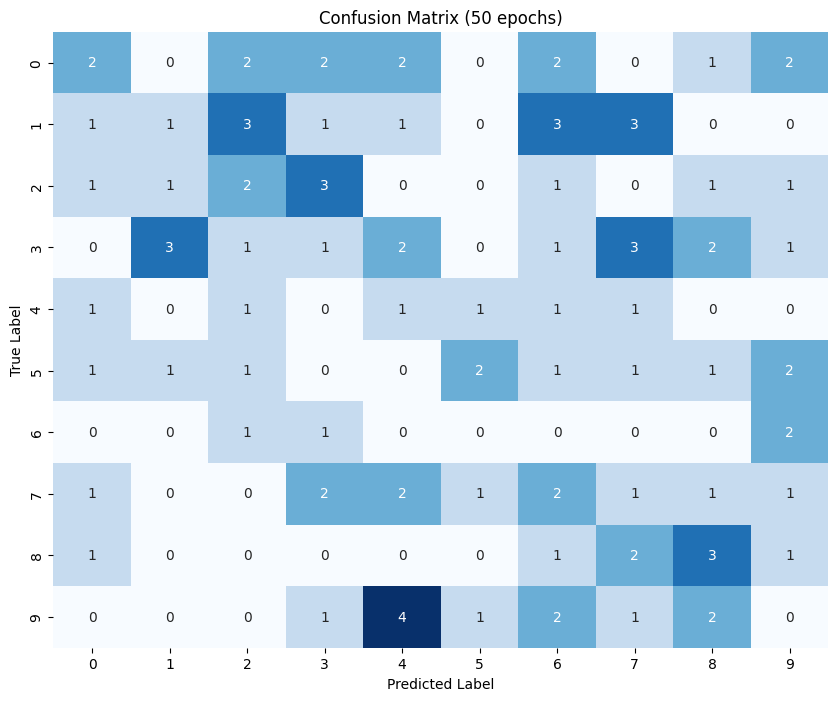

In [29]:
# Get all predictions and targets for the test set.
all_predictions, all_targets = get_all_predictions(rnn_lstm_50epochs, test_loader)

# Calculate confusion matrix.
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (50 epochs)')
plt.show()

##### 2. Generate the Classification report

It provides detailed evaluation metrics for each class in a multi-class classification problem for 50 epochs.

In [30]:
# Calculate classification report.
report = classification_report(all_targets, all_predictions, target_names=class_names)
print("Classification Report (50 epochs):")
print(report)

Classification Report (50 epochs):
              precision    recall  f1-score   support

       blues       0.25      0.15      0.19        13
   classical       0.17      0.08      0.11        13
     country       0.18      0.20      0.19        10
       disco       0.09      0.07      0.08        14
      hiphop       0.08      0.17      0.11         6
        jazz       0.40      0.20      0.27        10
       metal       0.00      0.00      0.00         4
         pop       0.08      0.09      0.09        11
      reggae       0.27      0.38      0.32         8
        rock       0.00      0.00      0.00        11

    accuracy                           0.13       100
   macro avg       0.15      0.13      0.13       100
weighted avg       0.16      0.13      0.14       100



##### 3. Calculate the Precision, Recall and F1-score

For each class, Calculate the Precision Recall and F1-score for 50 epochs. Also calculate the overall metrics.

In [31]:
# Calculate precision, recall, and F1-score for each class.
precision_per_class = precision_score(all_targets, all_predictions, average=None)
recall_per_class = recall_score(all_targets, all_predictions, average=None)
f1_per_class = f1_score(all_targets, all_predictions, average=None)

# Create a dictionary to store class-wise evaluation metrics.
class_metrics = {
    "Class": class_names,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1-score": f1_per_class
}

# Print class-wise evaluation metrics.
class_metrics_df = pd.DataFrame(class_metrics)
print("Class-wise Evaluation Metrics:")
print(class_metrics_df)

# Calculate overall evaluation metrics.
overall_precision = precision_score(all_targets, all_predictions, average='weighted')
overall_recall = recall_score(all_targets, all_predictions, average='weighted')
overall_f1 = f1_score(all_targets, all_predictions, average='weighted')

Class-wise Evaluation Metrics:
       Class  Precision    Recall  F1-score
0      blues   0.250000  0.153846  0.190476
1  classical   0.166667  0.076923  0.105263
2    country   0.181818  0.200000  0.190476
3      disco   0.090909  0.071429  0.080000
4     hiphop   0.083333  0.166667  0.111111
5       jazz   0.400000  0.200000  0.266667
6      metal   0.000000  0.000000  0.000000
7        pop   0.083333  0.090909  0.086957
8     reggae   0.272727  0.375000  0.315789
9       rock   0.000000  0.000000  0.000000


In [32]:
# Print overall evaluation metrics.
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)


Overall Precision: 0.1610606060606061
Overall Recall: 0.13
Overall F1-score: 0.13685544295521412


##### 4. Plot the Precision-Recall curve

For each class, Plot the Precision-Recall curve for 50 epochs.

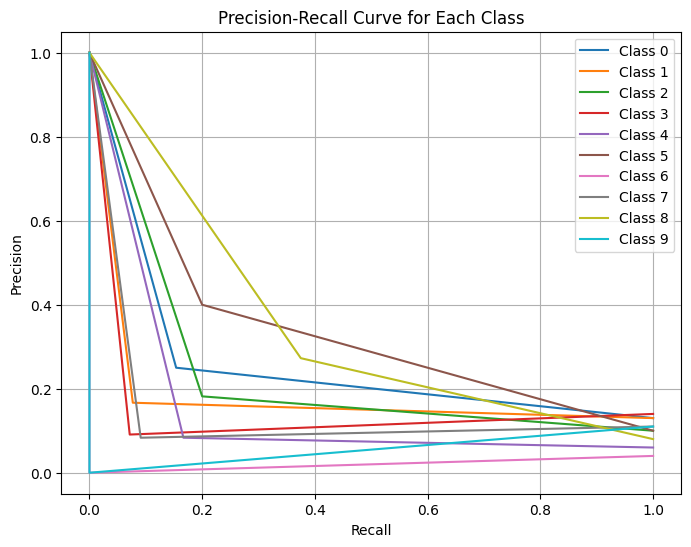

In [33]:
# Initialize empty lists to store precision and recall for each class.
precision_per_class = []
recall_per_class = []

# Iterate over each class.
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative.
    y_true_class = [1 if label == i else 0 for label in all_targets]
    y_score_class = [1 if label == i else 0 for label in all_predictions]   
    # Compute precision and recall for the current class.
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)    
    # Append precision and recall to the lists.
    precision_per_class.append(precision)
    recall_per_class.append(recall)

# Plot precision-recall curve for each class.
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall_per_class[i], precision_per_class[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()

##### 5. Calculate the area under the Precision-Recall curve.

For each class, Calculate the area under the Precision-Recall curve for 50 epochs.

In [34]:
# Initialize empty list to store area under curve for each class.
auc_per_class = []

# Iterate over each class.
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative.
    y_true_class = [1 if label == i else 0 for label in all_targets]
    y_score_class = [1 if label == i else 0 for label in all_predictions]
    # Compute precision and recall for the current class.
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
    # Calculate area under curve (AUC) for precision-recall curve of the current class.
    auc_class = auc(recall, precision)
    # Append AUC to the list.
    auc_per_class.append(auc_class)

# Print area under curve for each class.
for i in range(num_classes):
    print(f"Class {i}: AUC = {auc_per_class[i]}")

Class 0: AUC = 0.2569230769230769
Class 1: AUC = 0.1817948717948718
Class 2: AUC = 0.23090909090909095
Class 3: AUC = 0.14616883116883117
Class 4: AUC = 0.14999999999999997
Class 5: AUC = 0.33999999999999997
Class 6: AUC = 0.02
Class 7: AUC = 0.13712121212121212
Class 8: AUC = 0.3488636363636364
Class 9: AUC = 0.055


##### 6. Calculate class-wise accuracy.

For each class, Calculate class-wise accuracy for 50 epochs.

In [35]:
# Calculate class-wise accuracy.
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'blues' Accuracy: 0.1538
Class 'classical' Accuracy: 0.0769
Class 'country' Accuracy: 0.2000
Class 'disco' Accuracy: 0.0714
Class 'hiphop' Accuracy: 0.1667
Class 'jazz' Accuracy: 0.2000
Class 'metal' Accuracy: 0.0000
Class 'pop' Accuracy: 0.0909
Class 'reggae' Accuracy: 0.3750
Class 'rock' Accuracy: 0.0000


## 2. The same architecture as Net5, together with GANs generating audio samples augmenting the training audio samples 
##### (Generating the same number of audio samples as the original number of training audio samples).

This code defines the Generator and Discriminator networks, which are essential components of Generative Adversarial Networks (GANs), a deep learning architecture for creating synthetic data.

Generator:
The Generator creates synthetic data samples that mimic genuine data.


The __init__ function initializes the Generator module.
  - 'latent_dim' specifies the dimensionality of the input noise vector (latent space), which is usually a random vector drawn from a Gaussian distribution.
  - 'output_dim' represents the dimensionality of the created output data.
  - The generator model is made up of a series of completely linked (linear) layers followed by ReLU activation functions, with the exception of the last layer, which employs a Tanh activation. Tanh is widely used to scale the output to the range [-1, 1], which is appropriate for audio or visual data.
    
The 'forward' function defines the Generator's forward pass.
  - 'z' represents the input noise vector.
  - - The input noise vector 'z' is routed through the sequential model, which produces the output data.

Discriminator: The Discriminator is responsible for discriminating between authentic and fraudulent data samples.

The __init__ function initializes the Discriminator module.
  - 'input_dim' specifies the dimensionality of the input data samples (whether actual or created).
  - The discriminator model is made up of a series of completely linked layers followed by ReLU activation functions, with the exception of the last layer, which utilizes a Sigmoid function. Sigmoid reduces the output to a range of 0 to 1, signifying the chance that the input is real.
    
The 'forward' function defines the Discriminator's forward pass.
  - 'x' represents the input data sample (actual or created).
  - The input data sample 'x' is fed through the sequential model, yielding the discriminator's classification output, which indicates the likelihood that the input is a true data sample.r.

In short, the Generator creates bogus data samples from random noise, whereas the Discriminator attempts to discriminate between actual and fake data samples. During training, these two networks are repeatedly trained in a min-max game until the Generator learns to produce realistic examples that trick the discriminator.

In [25]:
# Define the Generator network.
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()    
        # Dimensionality of the input noise vector (latent space).
        self.latent_dim = latent_dim        
        # Dimensionality of the generated output data.
        self.output_dim = output_dim

        # Sequential model for the Generator.
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),          # Set linear layer latent_dim to 128 units.
            nn.ReLU(),                           # ReLU activation function.
            nn.Linear(128, 256),                 # Linear layer: 128 units to 256 units.
            nn.ReLU(),                           # ReLU activation function.
            nn.Linear(256, output_dim),          # Linear layer: 256 units to output_dim units.
            nn.Tanh()                            # Tanh activation function for audio samples- scales output to [-1, 1].
        )

    # Forward pass: Apply the sequential model to the input noise vector z.
    def forward(self, z):
        return self.model(z)

In [26]:
# Define the Discriminator network.
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # Dimensionality of the input data samples.
        self.input_dim = input_dim

        # Sequential model for the Discriminator.
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),           # Set linear layer input_dim to 256 units.
            nn.ReLU(),                           # ReLU activation function.
            nn.Linear(256, 128),                 # Linear layer: 256 units to 128 units.
            nn.ReLU(),                           # ReLU activation function.
            nn.Linear(128, 1),                   # Linear layer: 128 units to 1 unit.
            nn.Sigmoid()                         # Sigmoid activation function for binary classification- yields probability.
        )

    # Forward pass: use the sequential model with input data sample x.
    def forward(self, x):
        return self.model(x)

#### Class AudioDatasetGAN:

AudioDatasetGAN is tailored specifically for GAN training with labeled audio data.

In [27]:
class AudioDatasetGAN(torch.utils.data.Dataset):
    def __init__(self, audio_samples, labels):
        # Convert audio samples to PyTorch tensor
        self.audio_samples = torch.tensor(audio_samples)  
        # Convert labels to PyTorch tensor
        self.labels = torch.tensor(labels)  

    # Return the number of audio samples in the dataset
    def __len__(self):
        return len(self.audio_samples)

    # Get the audio sample and label as a tuple and return it
    def __getitem__(self, idx):
        return self.audio_samples[idx], self.labels[idx]

Now define the model parameters and print them.

In [28]:
# Initialize GAN parameters
latent_dim = 100                # Dimensionality of the latent space
output_dim = 220500             # Dimensionality of the output audio samples
input_dim = output_dim          # Dimensionality of the input to the discriminator
num_epochs_gan = 50             # Number of Epochs to run.
batch_size_gan = 32             # Batch size for training the GAN
learning_rate_gan = 0.0002       # Learning rate for training the GAN

In [29]:
# Print Model Parameters.
print("Model Parameters:")
print("Dimensionality of the latent space: ", latent_dim)              
print("Dimensionality of the output audio samples: ", output_dim)
print("Dimensionality of the input to the discriminator: ", input_dim)                  
print("Number of Epochs to run: ", num_epochs_gan)
print("Batch size for training the GAN: ", batch_size_gan)        
print("Learning rate: ", learning_rate_gan) 

Model Parameters:
Dimensionality of the latent space:  100
Dimensionality of the output audio samples:  220500
Dimensionality of the input to the discriminator:  220500
Number of Epochs to run:  50
Batch size for training the GAN:  32
Learning rate:  0.0002


This code creates a GAN with a generator and discriminator, configures a binary cross-entropy loss function for training, and defines Adam optimizers for both the generator and the discriminator with a defined learning rate.


In [30]:
# Initialize the GAN components.
# Initialize the Generator with the supplied latent and output dimensions.
generator = Generator(latent_dim, output_dim)

# Initialize the Discriminator with the specified input dimension.
discriminator = Discriminator(input_dim)

# Define loss function and optimizers for GAN.
# GANs generally employ Binary Cross Entropy Loss to assess the difference between two probability distributions.
criterion_gan = nn.BCELoss()

# Define optimizers for generators and discriminators. The Adam optimizer is often used to train neural networks.
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_gan)

# Discriminator optimizer is applied to the parameters of the Discriminator network.
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_gan)

In this GAN training loop, each epoch trains both the Generator and the Discriminator. The Discriminator learns to discriminate between real and false samples and adjusts its settings to reduce classification mistakes. Meanwhile, the Generator attempts to deceive the Discriminator by producing realistic samples and adjusting its settings based on the Discriminator's input. This iterative procedure runs for the set number of epochs, and progress is tracked using the shown Generator and Discriminator losses. The networks evolve over time as a result of mutual competition, with the Generator producing more convincing samples and the Discriminator becoming more discerning.

In [35]:
# Training loop for GAN.
for epoch in range(num_epochs_gan):
    for real_samples, _ in train_loader:
        # Determine the batch size for this iteration.
        batch_size_gan = real_samples.size(0) 

        # Train Discriminator.
        discriminator.zero_grad()
        # Convert real samples to float and reshape.
        real_samples = real_samples.view(-1, input_dim).float()
        # Define labels for real and fake samples.
        real_labels = torch.ones(batch_size_gan, 1)
        fake_labels = torch.zeros(batch_size_gan, 1)
        # Train discriminator on real samples.
        real_output = discriminator(real_samples)       
        # Adjust size of real_labels.
        real_loss = criterion_gan(real_output, real_labels[:batch_size_gan])  
        # Generate fake samples and train discriminator on fake samples.
        z = torch.randn(batch_size_gan, latent_dim)        
        # Detach to avoid training generator here.
        fake_samples = generator(z).detach()
        fake_output = discriminator(fake_samples)
        # Adjust size of fake_labels.
        fake_loss = criterion_gan(fake_output, fake_labels[:batch_size_gan]) 
        # Update discriminator parameters.
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()
        # Train Generator.
        generator.zero_grad()
        # Generate fake samples again for training the Generator.
        z = torch.randn(batch_size_gan, latent_dim)
        fake_samples = generator(z)
        output = discriminator(fake_samples)     
        # Adjust size of real_labels.
        generator_loss = criterion_gan(output, real_labels[:batch_size_gan]) 
        # Update generator parameters.
        generator_loss.backward()
        generator_optimizer.step()

    # Print progress.
    if epoch:
        print(f"GAN Epoch [{epoch}/{num_epochs_gan}], Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}")

GAN Epoch [1/50], Generator Loss: 4.9902, Discriminator Loss: 0.2640
GAN Epoch [2/50], Generator Loss: 6.9037, Discriminator Loss: 0.2980
GAN Epoch [3/50], Generator Loss: 8.0674, Discriminator Loss: 0.1005
GAN Epoch [4/50], Generator Loss: 15.8074, Discriminator Loss: 0.0289
GAN Epoch [5/50], Generator Loss: 19.7820, Discriminator Loss: 0.0411
GAN Epoch [6/50], Generator Loss: 14.0569, Discriminator Loss: 0.0720
GAN Epoch [7/50], Generator Loss: 11.1935, Discriminator Loss: 0.0825
GAN Epoch [8/50], Generator Loss: 10.5612, Discriminator Loss: 0.2364
GAN Epoch [9/50], Generator Loss: 8.3653, Discriminator Loss: 0.0248
GAN Epoch [10/50], Generator Loss: 9.2587, Discriminator Loss: 0.0094
GAN Epoch [11/50], Generator Loss: 12.9847, Discriminator Loss: 0.0129
GAN Epoch [12/50], Generator Loss: 14.0568, Discriminator Loss: 0.2490
GAN Epoch [13/50], Generator Loss: 23.1423, Discriminator Loss: 0.3091
GAN Epoch [14/50], Generator Loss: 19.6662, Discriminator Loss: 0.3022
GAN Epoch [15/50], G

A custom neural network module called Net6 is developed (same as Net5 architecture),. It uses a Long Short-Term Memory (LSTM) layer followed by a fully connected (linear) layer. The LSTM layer takes sequential input data, and the last time step's hidden state is sent into the fully connected layer to generate the final output prediction.

In [31]:
class Net6(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Net6, self).__init__()     
        # Define the size of the input, hidden, and output layers.
        self.hidden_size = hidden_size
        self.num_layers = num_layers        
        # Define the LSTM layer with specified input size, hidden size, and number of layers.
        # Set batch_first=True to make the output 2D.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Define the fully connected (linear) layer to map the LSTM output to the output classes.
        self.fc = nn.Linear(hidden_size, num_classes)

    # Forward pass through LSTM layer.
    def forward(self, x):  
        # Returns the hidden state for each time step and the final hidden state.
        _, (hn, _) = self.lstm(x)
        # Decode the hidden state of the last time step.
        # Access the last layer's hidden state to use as input for the fully connected layer.
        out = self.fc(hn[-1])  
        return out

This method generates real audio samples from the dataset by iterating over batches in the 'train_loader', extracting audio samples, and adding them to a list. Finally, it transforms the audio sample list to a NumPy array, which may then be processed or analyzed.

In [32]:
# Prepare real audio samples from the actual dataset
real_audio_samples = []

# Iterate over the train_loader to collect audio samples
for batch in train_loader:
    audio_batch, _ = batch  # Assuming each batch contains a tuple of (audio_samples, labels)
    for audio_sample in audio_batch:
        real_audio_samples.append(audio_sample.numpy())

# Convert the list of audio samples into a numpy array
real_audio_samples = np.array(real_audio_samples)

#### Function train_model_gan:

This function trains a PyTorch model using GAN principles. It iterates for the specified number of epochs, processing audio data from the training loader, calculating the loss, and updating the model parameters via backpropagation. It displays the average loss each epoch as the training advances.

In [33]:
def train_model_gan(model, criterion, optimizer, train_loader, num_epochs):
    # Set the model to training mode.
    model.train()

    # Iterate over the specified number of epochs.
    for epoch in range(num_epochs): 
        # Initialize the running loss.
        running_loss = 0.0

        # Iterate over the batches in the train loader.
        for audio_data, labels in train_loader:
            # Flatten the input audio data.
            audio_data = audio_data.view(audio_data.size(0), -1).to(device)
            # Zero the parameter gradients.
            optimizer.zero_grad()
            # Forward pass: compute the model outputs.
            outputs = model(audio_data)
            # Calculate the loss.
            loss = criterion(outputs.squeeze(), labels.long())
            # Backward pass: compute gradients and update parameters.
            loss.backward()
            optimizer.step()
            # Accumulate the running loss for this batch.
            running_loss += loss.item() * audio_data.size(0)

        # Compute the epoch loss by dividing the total running loss by the dataset size and print it.
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

This code section starts by creating synthetic audio samples using a trained GAN model. It then blends these synthetic samples with actual ones to ensure that they meet a certain maximum length. A new dataset is created by integrating them with the associated labels. It then initializes an RNN-LSTM model and trains it on the updated dataset, outputting the output shape and signaling that training is complete.

In [34]:
# Generate synthetic audio samples using the trained GAN model.
synthetic_samples = []
with torch.no_grad():
    for _ in range(len(train_dataset)):
        z = torch.randn(1, latent_dim)
        # Generate synthetic sample.
        fake_sample = generator(z).squeeze().numpy()  
        synthetic_samples.append(fake_sample)

In [35]:
# Assuming max_length is the maximum length of audio samples.
max_length = 220500

# Padding or trimming audio samples to match the maximum length.
for i in range(len(synthetic_samples)):
    audio_length = len(synthetic_samples[i])
    if audio_length < max_length:
        synthetic_samples[i] = np.pad(synthetic_samples[i], (0, max_length - audio_length))
    elif audio_length > max_length:
        synthetic_samples[i] = synthetic_samples[i][:max_length]

In [36]:
# Convert list of synthetic samples to a numpy array.
synthetic_samples = np.array(synthetic_samples) 

# Limit the number of synthetic samples to 32 for demonstration purposes.
synthetic_samples = synthetic_samples[:32, :] 

# Combine original and synthetic samples with their corresponding labels.
combined_audio_samples = np.concatenate((real_audio_samples, synthetic_samples), axis=0)
combined_labels = np.concatenate((np.ones(len(real_audio_samples)), np.zeros(len(synthetic_samples))), axis=0)

# Create a new dataset with the combined samples and labels.
augmented_dataset = AudioDatasetGAN(combined_audio_samples, combined_labels)

In [37]:
input_size = max_length

# Initialize the RNN-LSTM model.
rnn_lstm_with_augmentation = Net6(input_size, hidden_size, num_layers, num_classes).to(device)

# Define loss function and optimizer.
criterion_rnn = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(rnn_lstm_with_augmentation.parameters(), lr=0.001)


In [38]:
# Preprocess input data.
# Shape: (batch_size, input_size).
audios = audios.view(audios.size(0), -1) 

# Call the model on the preprocessed input data.
outputs = rnn_lstm_with_augmentation(audios)

print("Output shape from the RNN-LSTM model:", outputs.shape)

Output shape from the RNN-LSTM model: torch.Size([10])


In [41]:
# Train the RNN-LSTM model using the augmented dataset.
train_model_gan(rnn_lstm_with_augmentation, criterion_rnn, optimizer_rnn, augmented_dataset, num_epochs_rnn) 
print("Training complete!")

Epoch [1/50], Loss: 3.027
Epoch [2/50], Loss: 3.004
Epoch [3/50], Loss: 2.9768
Epoch [4/50], Loss: 2.7650
Epoch [5/50], Loss: 2.4921
Epoch [6/50], Loss: 2.2398
Epoch [7/50], Loss: 2.027
Epoch [8/50], Loss: 1.9876
Epoch [9/50], Loss: 1.8826
Epoch [10/50], Loss: 1.7682
Epoch [11/50], Loss: 1.7273
Epoch [12/50], Loss: 1.4839
Epoch [13/50], Loss: 1.2981
Epoch [14/50], Loss: 1.0928
Epoch [15/50], Loss: 1.0672
Epoch [16/50], Loss: 1.0549
Epoch [17/50], Loss: 1.0428
Epoch [18/50], Loss: 1.0381
Epoch [19/50], Loss: 1.0298
Epoch [20/50], Loss: 1.0175
Epoch [21/50], Loss: 1.0132
Epoch [22/50], Loss: 1.0097
Epoch [23/50], Loss: 1.0041
Epoch [24/50], Loss: 0.9982
Epoch [25/50], Loss: 0.9762
Epoch [26/50], Loss: 0.9532
Epoch [27/50], Loss: 0.8954
Epoch [28/50], Loss: 0.8230
Epoch [29/50], Loss: 0.7639
Epoch [30/50], Loss: 0.6991
Epoch [31/50], Loss: 0.6719
Epoch [32/50], Loss: 0.5892
Epoch [33/50], Loss: 0.4551
Epoch [34/50], Loss: 0.3875
Epoch [35/50], Loss: 0.2967
Epoch [36/50], Loss: 0.2893
Epoc

#### Evaluation on Training set

Calculate the accuracy of Net6 on the training set after 50 epochs.

In [57]:
# Evaluate Net6 on the training set after 50 epochs.
train_accuracy_net6_50epochs = evaluate_model(rnn_lstm_with_augmentation, train_loader)
print(f"Training Accuracy after 50 epochs: {train_accuracy_net6_50epochs:.4f}")

Training Accuracy after 50 epochs: 0.0986


#### Validation

Validate Net6 Model by calculating the accuracy of the model on the validation set.

In [61]:
# Evaluate LSTM on the validation set after 50 epochs.
val_accuracy_net6_50epochs = evaluate_model(rnn_lstm_with_augmentation, val_loader)
print(f"Validation Accuracy after 50 epochs: {val_accuracy_net6_50epochs:.4f}")

Validation Accuracy after 50 epochs: 0.1100


#### Testing

Test the Net6 Model on the test dataset.

In [62]:
# Evaluate LSTM on the test set after 50 epochs.
test_accuracy_net6_50epochs = evaluate_model(rnn_lstm_with_augmentation, test_loader)
print(f"Test Accuracy after 50 epochs: {test_accuracy_net6_50epochs:.4f}")

Test Accuracy after 50 epochs: 0.0900


#### Evaluation of all the results of Net5
##### 1. Create Confusion Matrix

Plot a Confusion matrix for 50 epochs.

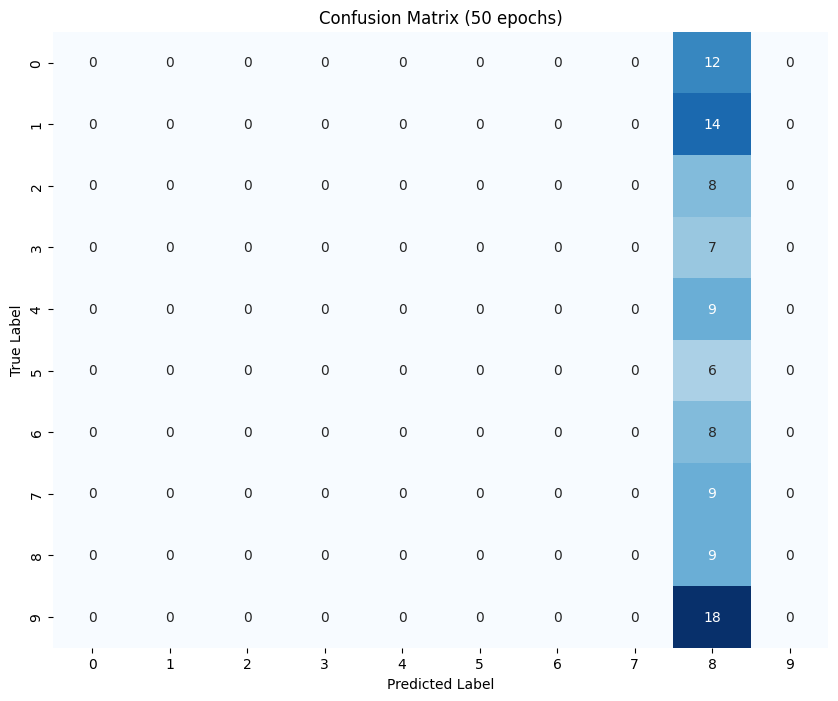

In [65]:
# Get all predictions and targets for the test set.
all_predictions, all_targets = get_all_predictions(rnn_lstm_with_augmentation, test_loader)

# Calculate confusion matrix.
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (50 epochs)')
plt.show()

##### 2. Generate the Classification report

It provides detailed evaluation metrics for each class in a multi-class classification problem for 50 epochs.

In [68]:
# Calculate classification report.
report = classification_report(all_targets, all_predictions, target_names=class_names, zero_division=1)
print("Classification Report (50 epochs):")
print(report)

Classification Report (50 epochs):
              precision    recall  f1-score   support

       blues       1.00      0.00      0.00        12
   classical       1.00      0.00      0.00        14
     country       1.00      0.00      0.00         8
       disco       1.00      0.00      0.00         7
      hiphop       1.00      0.00      0.00         9
        jazz       1.00      0.00      0.00         6
       metal       1.00      0.00      0.00         8
         pop       1.00      0.00      0.00         9
      reggae       0.09      1.00      0.17         9
        rock       1.00      0.00      0.00        18

    accuracy                           0.09       100
   macro avg       0.91      0.10      0.02       100
weighted avg       0.92      0.09      0.01       100



##### 3. Calculate the Precision, Recall and F1-score

For each class, Calculate the Precision Recall and F1-score for 50 epochs. Also calculate the overall metrics.

In [79]:
# Calculate precision, recall, and F1-score for each class.
precision_per_class = precision_score(all_targets, all_predictions, average=None, zero_division=1)
recall_per_class = recall_score(all_targets, all_predictions, average=None, zero_division=1)
f1_per_class = f1_score(all_targets, all_predictions, average=None, zero_division=1)

# Create a dictionary to store class-wise evaluation metrics.
class_metrics = {
    "Class": class_names,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1-score": f1_per_class
}

# Print class-wise evaluation metrics.
class_metrics_df = pd.DataFrame(class_metrics)
print("Class-wise Evaluation Metrics:")
print(class_metrics_df)

# Calculate overall evaluation metrics.
overall_precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
overall_recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
overall_f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)


Class-wise Evaluation Metrics:
       Class  Precision  Recall  F1-score
0      blues       1.00     0.0  0.000000
1  classical       1.00     0.0  0.000000
2    country       1.00     0.0  0.000000
3      disco       1.00     0.0  0.000000
4     hiphop       1.00     0.0  0.000000
5       jazz       1.00     0.0  0.000000
6      metal       1.00     0.0  0.000000
7        pop       1.00     0.0  0.000000
8     reggae       0.09     1.0  0.165138
9       rock       1.00     0.0  0.000000


In [81]:
# Print overall evaluation metrics.
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)

Overall Precision: 0.9181
Overall Recall: 0.09
Overall F1-score: 0.014862385321100915


##### 4. Plot the Precision-Recall curve

For each class, Plot the Precision-Recall curve for 50 epochs.

In [82]:
# Initialize empty lists to store precision and recall for each class.
precision_per_class = []
recall_per_class = []

# Iterate over each class.
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative.
    y_true_class = [1 if label == i else 0 for label in all_targets]
    y_score_class = [1 if label == i else 0 for label in all_predictions]
    
    # Compute precision and recall for the current class.
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
    
    # Append precision and recall to the lists.
    precision_per_class.append(precision)
    recall_per_class.append(recall)

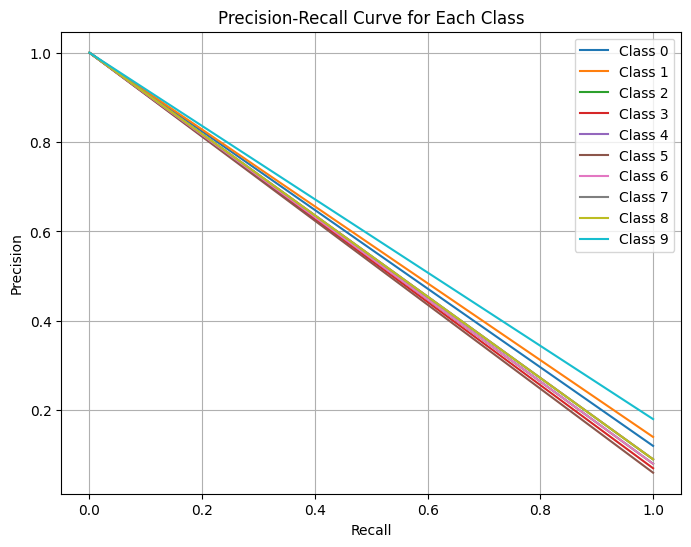

In [83]:
# Plot precision-recall curve for each class.
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall_per_class[i], precision_per_class[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()

##### 5. Calculate the area under the Precision-Recall curve.

For each class, Calculate the area under the Precision-Recall curve for 50 epochs.

In [84]:
# Initialize empty list to store area under curve for each class.
auc_per_class = []

# Iterate over each class.
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative.
    y_true_class = [1 if label == i else 0 for label in all_targets]
    y_score_class = [1 if label == i else 0 for label in all_predictions]
    # Compute precision and recall for the current class.
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
    # Calculate area under curve (AUC) for precision-recall curve of the current class.
    auc_class = auc(recall, precision)
    # Append AUC to the list.
    auc_per_class.append(auc_class)

# Print area under curve for each class.
for i in range(num_classes):
    print(f"Class {i}: AUC = {auc_per_class[i]}")

Class 0: AUC = 0.56
Class 1: AUC = 0.5700000000000001
Class 2: AUC = 0.54
Class 3: AUC = 0.535
Class 4: AUC = 0.545
Class 5: AUC = 0.53
Class 6: AUC = 0.54
Class 7: AUC = 0.545
Class 8: AUC = 0.545
Class 9: AUC = 0.59


##### 6. Calculate class-wise accuracy.

For each class, Calculate class-wise accuracy for 50 epochs.

In [85]:
# Calculate class-wise accuracy.
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'blues' Accuracy: 0.0000
Class 'classical' Accuracy: 0.0000
Class 'country' Accuracy: 0.0000
Class 'disco' Accuracy: 0.0000
Class 'hiphop' Accuracy: 0.0000
Class 'jazz' Accuracy: 0.0000
Class 'metal' Accuracy: 0.0000
Class 'pop' Accuracy: 0.0000
Class 'reggae' Accuracy: 1.0000
Class 'rock' Accuracy: 0.0000
